In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import tqdm
import utils as utils
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import run, get_params
from src.preprocessing.glob import load_emissions_dataset, load_response_dataset
from src.models import ThermalBoxesGP
from src.likelihoods import InternalVariability
from src.structures import Scenario, ScenarioDataset

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [4]:
train_keys = ['historical', 'ssp245', 'ssp370', 'ssp585']
test_keys = ['ssp126']
keys = train_keys + test_keys
inputs = {key: load_emissions_dataset(f'../data/inputs_{key}.nc') for key in keys}
outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in keys}

def make_scenario(name, hist_scenario=None):
    time, _, emission, tas = utils.extract_arrays(inputs[name], outputs[name])
    scenario = Scenario(name=name,
                        timesteps=torch.from_numpy(time).float(),
                        emissions=torch.from_numpy(emission).float().T,
                        tas=torch.from_numpy(tas).float(),
                        hist_scenario=hist_scenario)
    return scenario

In [5]:
hist_scenario = make_scenario('historical')
ssps = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
scenarios = {'historical': hist_scenario}
for name in ssps:
    scenario = make_scenario(name, hist_scenario)
    scenarios[name] = scenario
    
train_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in train_keys]),
                                  hist_scenario=hist_scenario)
test_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in test_keys]),
                                 hist_scenario=hist_scenario)

In [6]:
base_kwargs = utils.get_fair_params()
d = base_kwargs['d']
q = base_kwargs['q']

kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[1, 2, 3, 4])
kernel = kernels.ScaleKernel(kernel)

In [8]:
likelihood = InternalVariability(d=d, q=q, add_observation_noise=True)
model = ThermalBoxesGP(scenario_dataset=train_scenarios,
                       kernel=kernel,
                       likelihood=likelihood,
                       q=q, d=d)

In [9]:
# Find optimal model hyperparameters
model.train()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
n_iter = 70
training_iter = tqdm.notebook.tqdm(range(n_iter), desc='Iter')

for i in training_iter:
    optimizer.zero_grad()
    output = model()
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()
    training_iter.set_postfix_str(f"LL = {-loss.item()}")

Iter:   0%|          | 0/70 [00:00<?, ?it/s]

In [29]:
# torch.save(model.state_dict(), './state_dict_ssp126out.pt')
# state_dict = torch.load('./state_dict_ssp126out.pt')
# model.load_state_dict(state_dict)

# model.kernel.outputscale = 0.546323
# model.kernel.lengthscale = torch.tensor([1.384105, 2.023078, 0.042054, 0.05066])
# likelihood.raw_outputscale = nn.Parameter(torch.log(torch.exp(torch.tensor(0.672314)) - 1))
# model.OU_kernel.outputscale = 0.025922

In [13]:
def get_lengthscales_df(model):
    sigmaF = model.kernel.outputscale.detach().numpy()
    lengthscales = model.kernel.base_kernel.lengthscale.detach().flatten().numpy()
    sigmaOU = likelihood.outputscale.detach().numpy()
    noise = likelihood.observation_likelihood.noise.detach().numpy()
    data = np.append(lengthscales, sigmaF)
    data = np.append(data, sigmaOU)
    data = np.append(data, noise).reshape(1, -1)
    columns = ['CO2', 'CH4', 'SO2', 'BC', 'σF', 'σOU', 'σnoise']
    index = [1]
    return pd.DataFrame(data=data, columns=columns, index=index).rename_axis('Box')
get_lengthscales_df(model)

,CO2,CH4,SO2,BC,σF,σOU,σnoise
Box,,,,,,,
1,1.11503,3.085494,0.043376,0.028283,0.375016,0.177427,0.009842


In [14]:
test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas
test_tas_fair = model._compute_mean(test_scenarios)

model = model.eval()

with torch.no_grad():
    test_prior = model.forward(test_scenarios)
    noisy_test_prior = likelihood(test_prior)

with torch.no_grad():
    test_posterior = model(test_scenarios)
    noisy_test_posterior = likelihood(test_posterior)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


In [16]:
prior_mean = test_prior.mean + test_tas_fair
prior_lb, prior_ub = test_prior.confidence_region()
prior_lb = prior_lb.detach() + test_tas_fair
prior_ub = prior_ub.detach() + test_tas_fair

noisy_prior_lb, noisy_prior_ub = noisy_test_prior.confidence_region()
noisy_prior_lb = noisy_prior_lb.detach() + test_tas_fair
noisy_prior_ub = noisy_prior_ub.detach() + test_tas_fair

posterior_mean = test_posterior.mean + test_tas_fair
posterior_lb, posterior_ub = test_posterior.confidence_region()
posterior_lb = posterior_lb.detach() + test_tas_fair
posterior_ub = posterior_ub.detach() + test_tas_fair

noisy_posterior_lb, noisy_posterior_ub = noisy_test_posterior.confidence_region()
noisy_posterior_lb = noisy_posterior_lb.detach() + test_tas_fair
noisy_posterior_ub = noisy_posterior_ub.detach() + test_tas_fair

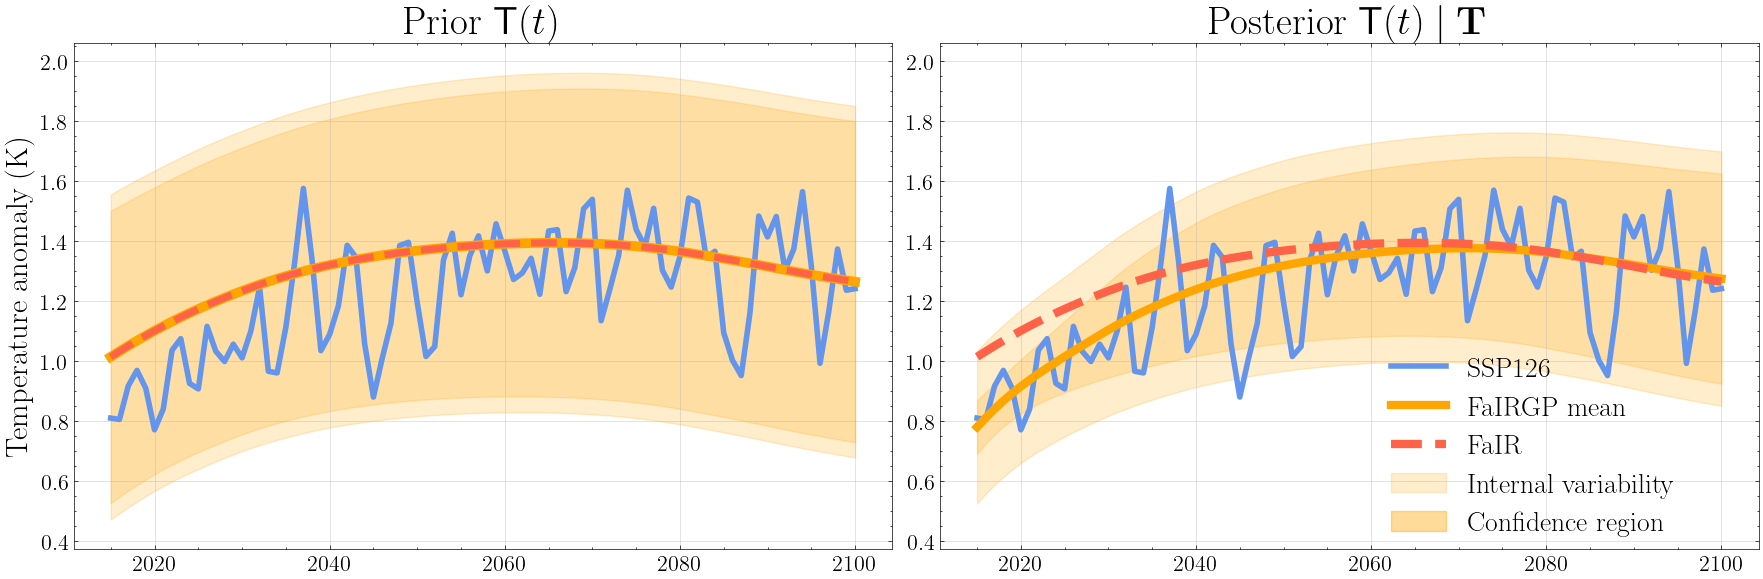

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ymax = max(noisy_prior_ub.max(), noisy_posterior_ub.max()) + 1e-1
ymin = min(noisy_prior_lb.min(), noisy_posterior_lb.min()) - 1e-1


ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].plot(test_times, prior_mean, color='orange', lw=7, label='Prior mean')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0].fill_between(test_times, prior_lb, prior_ub, alpha=0.2, color='orange')
ax[0].fill_between(test_times, noisy_prior_lb, noisy_prior_ub, alpha=0.2, color='orange')
ax[0].tick_params(labelsize=16)
ax[0].grid(alpha=0.5)
ax[0].set_ylim(ymin, ymax)
ax[0].set_title(r'Prior $\mathsf{T}(t)$', fontsize=28)

ax[1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[1].plot(test_times, posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[1].fill_between(test_times, noisy_posterior_lb, noisy_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[1].tick_params(labelsize=16)
ax[1].grid(alpha=0.5)
ax[1].set_ylim(ymin, ymax)
ax[1].set_title(r'Posterior $\mathsf{T}(t)\mid \mathbf{T}$', fontsize=28)

legend = plt.legend(loc='upper left', bbox_to_anchor=(0.52, 0.43), fontsize=20)
legend.legendHandles[4].set_alpha(0.4)

plt.tight_layout()
plt.savefig('SSP126-prediction.png', dpi=300)
plt.show()

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


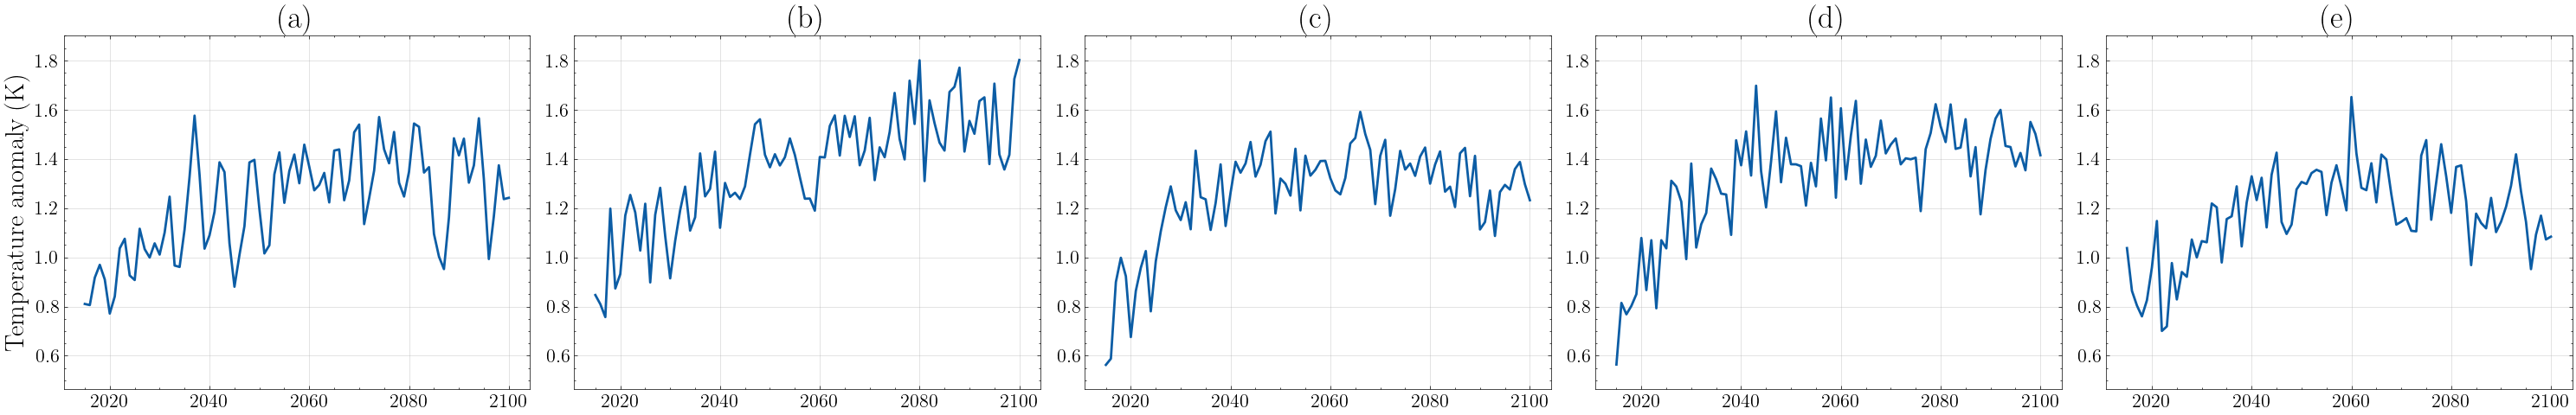

In [73]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))

torch.random.manual_seed(5)
draws = noisy_test_posterior.sample((5,))

draws = draws + test_tas_fair
rdm_idx = torch.randperm(5)

ymax = max(draws.max(), test_tas.max()) + 1e-1
ymin = min(draws.min(), test_tas.min()) - 1e-1

for i in rdm_idx[:-1]:
    ax[i].plot(test_times, draws[i], lw=2)
ax[rdm_idx[-1]].plot(test_times, test_tas, lw=2)

titles = ['(a)', '(b)', '(c)', '(d)', '(e)']
for i in range(5):
    ax[i].grid(alpha=0.5)
    ax[i].set_ylim(ymin, ymax)
    ax[i].tick_params(labelsize=16)
    ax[i].set_title(titles[i], fontsize=26)

ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)

plt.tight_layout()
plt.savefig('posterior-samples.png', dpi=300)
plt.show()

In [16]:
prior_mean = test_prior.mean + test_tas_fair
prior_lb, prior_ub = test_prior.confidence_region()
prior_lb = prior_lb.detach() + test_tas_fair
prior_ub = prior_ub.detach() + test_tas_fair

noisy_prior_lb, noisy_prior_ub = noisy_test_prior.confidence_region()
noisy_prior_lb = noisy_prior_lb.detach() + test_tas_fair
noisy_prior_ub = noisy_prior_ub.detach() + test_tas_fair

posterior_mean = test_posterior.mean + test_tas_fair
posterior_lb, posterior_ub = test_posterior.confidence_region()
posterior_lb = posterior_lb.detach() + test_tas_fair
posterior_ub = posterior_ub.detach() + test_tas_fair

noisy_posterior_lb, noisy_posterior_ub = noisy_pred.confidence_region()
noisy_posterior_lb = noisy_posterior_lb.detach() + test_tas_fair
noisy_posterior_ub = noisy_posterior_ub.detach() + test_tas_fair

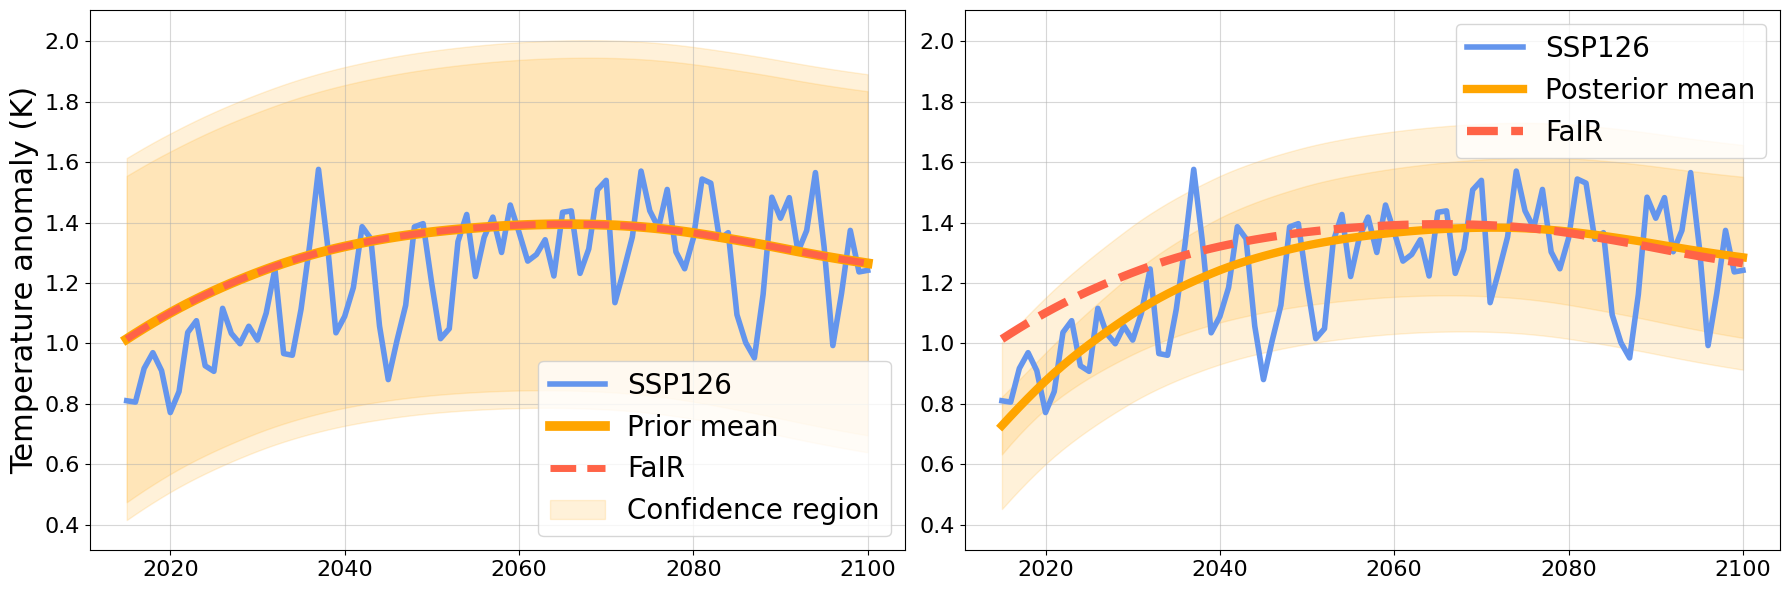

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ymax = max(noisy_prior_ub.max(), noisy_posterior_ub.max()) + 1e-1
ymin = min(noisy_prior_lb.min(), noisy_posterior_lb.min()) - 1e-1


ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].plot(test_times, prior_mean, color='orange', lw=7, label='Prior mean')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0].fill_between(test_times, noisy_prior_lb, noisy_prior_ub, alpha=0.15, color='orange')
ax[0].fill_between(test_times, prior_lb, prior_ub, alpha=0.15, color='orange', label='Confidence region')
ax[0].tick_params(labelsize=16)
ax[0].grid(alpha=0.5)
ax[0].set_ylim(ymin, ymax)
ax[0].legend(fontsize=20)

ax[1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[1].plot(test_times, posterior_mean, color='orange', lw=6, label='Posterior mean')
ax[1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1].fill_between(test_times, noisy_posterior_lb, noisy_posterior_ub, alpha=0.15, color='orange')
ax[1].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.15, color='orange')
ax[1].tick_params(labelsize=16)
ax[1].grid(alpha=0.5)
ax[1].set_ylim(ymin, ymax)
ax[1].legend(fontsize=20)

plt.tight_layout()
plt.show()

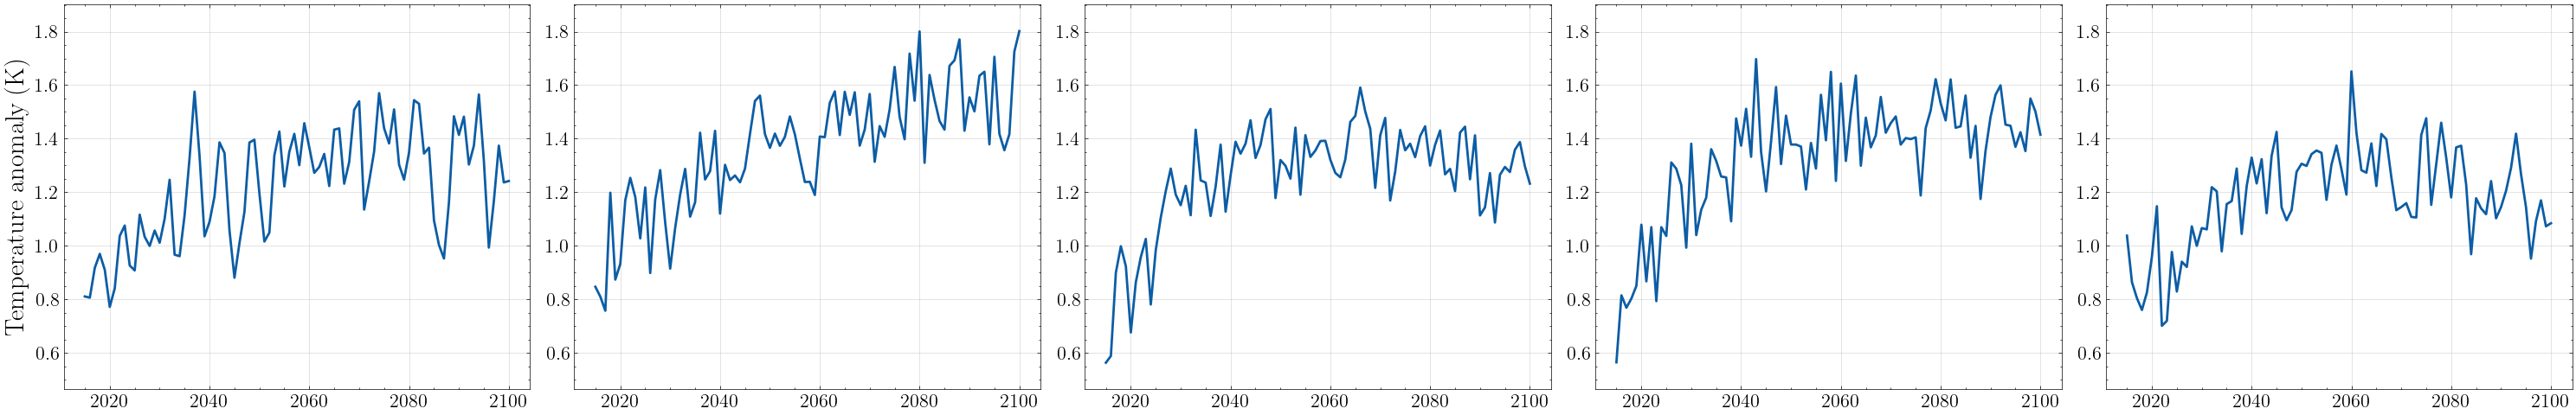

In [44]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))

torch.random.manual_seed(5)
draws = noisy_test_posterior.sample_n(5)

draws = draws + test_tas_fair
rdm_idx = torch.randperm(5)

ymax = max(draws.max(), test_tas.max()) + 1e-1
ymin = min(draws.min(), test_tas.min()) - 1e-1

for i in rdm_idx[:-1]:
    ax[i].plot(test_times, draws[i], lw=2)
    ax[i].grid(alpha=0.5)
    ax[i].tick_params(labelsize=16)
    ax[i].set_ylim(ymin, ymax)
ax[rdm_idx[-1]].plot(test_times, test_tas, lw=2)
ax[rdm_idx[-1]].grid(alpha=0.5)
ax[rdm_idx[-1]].tick_params(labelsize=16)
ax[rdm_idx[-1]].set_ylim(ymin, ymax)

ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
plt.tight_layout()
plt.show()

In [39]:
# # Add basic GP predictions
# from src.models import ExactGP
# mean = means.ZeroMean()
# kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3])
# likelihood = likelihoods.GaussianLikelihood()
# X = torch.cat([train_scenarios.cum_emissions[:, 0, None], 
#                train_scenarios.emissions[:, 1:]], dim=-1)
# mu, sigma = X.mean(dim=0), X.std(dim=0)
# X = (X - mu) / sigma
# y = (train_scenarios.tas - train_scenarios.mu_tas) / train_scenarios.sigma_tas
# model = ExactGP(X=X,
#                 y=y,
#                 mean=mean,
#                 kernel=kernel,
#                 likelihood=likelihood,
#                 mu=mu,
#                 sigma=sigma,
#                 mu_targets=train_scenarios.mu_tas,
#                 sigma_targets=train_scenarios.sigma_tas)
# state_dict = torch.load('./plain-gp-ssp126out/state_dict.pt')
# model.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: './plain-gp-ssp126out/state_dict.pt'

In [32]:
model = model.eval()
X_test = torch.cat([test_scenarios.cum_emissions[:, 0, None],
                    test_scenarios.emissions[:, 1:]], dim=-1)
X_test = (X_test - model.mu) / model.sigma

with torch.no_grad():
    gp_test_prior = model.forward(X_test)
    gp_test_noisy_prior = likelihood(gp_test_prior)
    gp_test_posterior = model(X_test)
    gp_noisy_pred = likelihood(gp_test_posterior)
    
gp_prior_mean = gp_test_noisy_prior.mean + test_tas_fair
gp_prior_lb, gp_prior_ub = gp_test_noisy_prior.confidence_region()
gp_prior_lb = gp_prior_lb + test_tas_fair
gp_prior_ub = gp_prior_ub + test_tas_fair

gp_posterior_mean =  gp_noisy_pred.mean + test_tas_fair
gp_posterior_lb, gp_posterior_ub = gp_noisy_pred.confidence_region()
gp_posterior_lb = gp_posterior_lb + test_tas_fair
gp_posterior_ub = gp_posterior_ub + test_tas_fair

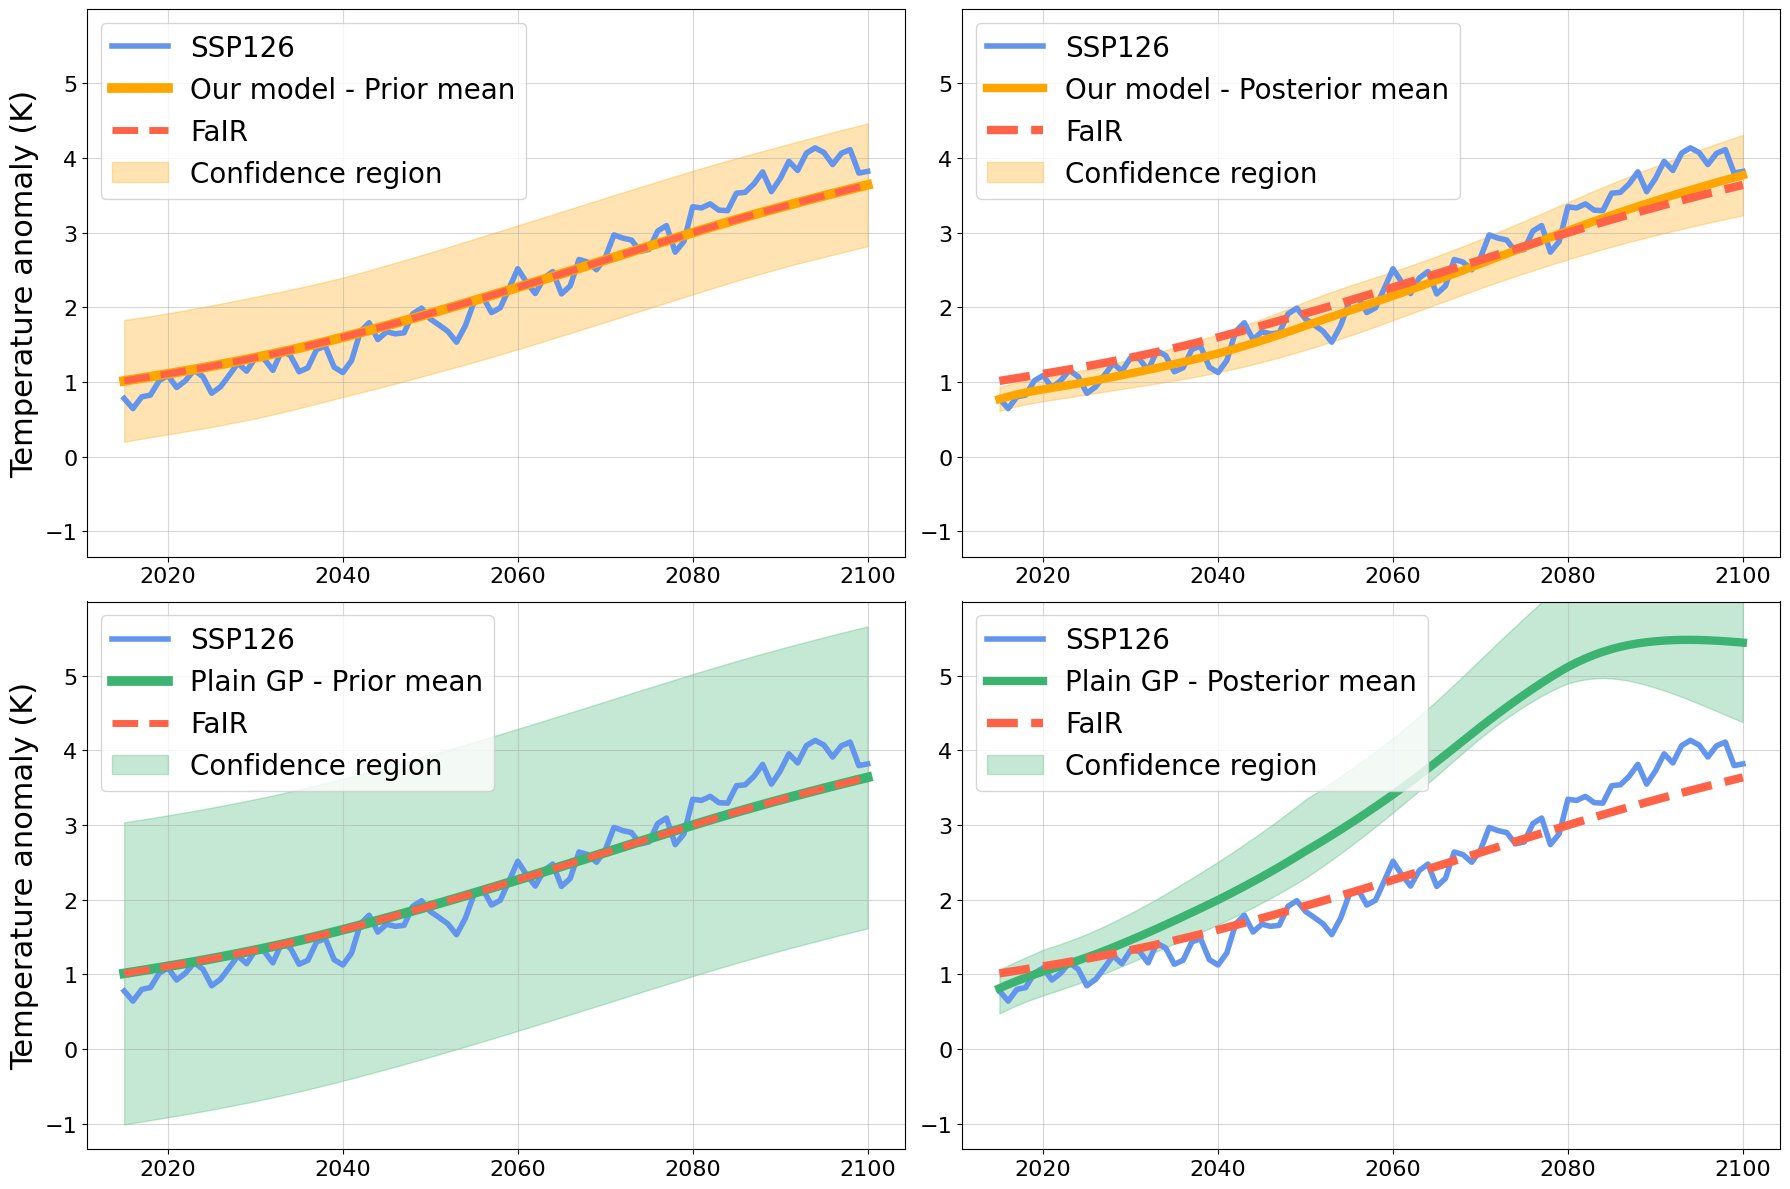

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

ax[1, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[1, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 0].plot(test_times, gp_prior_mean, color='mediumseagreen', lw=7, label='Plain GP - Prior mean')
ax[1, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[1, 0].fill_between(test_times, gp_prior_lb, gp_prior_ub, alpha=0.3, color='mediumseagreen', label='Confidence region')
ax[1, 0].tick_params(labelsize=16)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].legend(fontsize=20, loc='upper left')
ymin, ymax = ax[1, 0].get_ylim()

ax[1, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
# ax[1, 1].set_ylabel('Temperature anomaly (K)', fontsize=20)
ax[1, 1].plot(test_times, gp_posterior_mean, color='mediumseagreen', lw=6, label='Plain GP - Posterior mean')
ax[1, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 1].fill_between(test_times, gp_posterior_lb, gp_posterior_ub, alpha=0.3, color='mediumseagreen', label='Confidence region')
ax[1, 1].tick_params(labelsize=16)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].legend(fontsize=20, loc='upper left')
ax[1, 1].set_ylim(ymin, ymax)


ax[0, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[0, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0, 0].plot(test_times, prior_mean, color='orange', lw=7, label='Our model - Prior mean')
ax[0, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0, 0].fill_between(test_times, prior_lb, prior_ub, alpha=0.3, color='orange', label='Confidence region')
ax[0, 0].tick_params(labelsize=16)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].legend(fontsize=20, loc='upper left')
ax[0, 0].set_ylim(ymin, ymax)


ax[0, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
# ax[0, 1].set_ylabel('Temperature anomaly (K)', fontsize=20)
ax[0, 1].plot(test_times, posterior_mean, color='orange', lw=6, label='Our model - Posterior mean')
ax[0, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[0, 1].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.3, color='orange', label='Confidence region')
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].legend(fontsize=20, loc='upper left')
ax[0, 1].set_ylim(ymin, ymax)


plt.tight_layout()
plt.show()

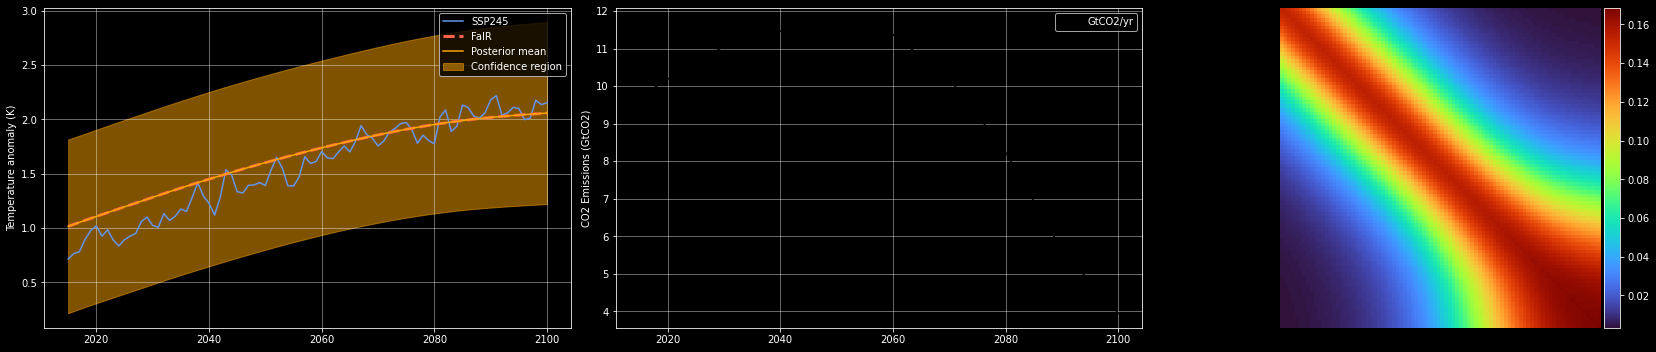

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))


ax[0].plot(test_times, test_tas, color='cornflowerblue', label='SSP245')
ax[0].set_ylabel('Temperature anomaly (K)')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=3, label='FaIR')
ax[0].plot(test_times, prior_mean, color='orange', label='Posterior mean')
ax[0].fill_between(test_times, prior_lb, prior_ub, alpha=0.5, color='orange', label='Confidence region')
ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].plot(test_times, test_scenarios.emissions[:, 0], label='GtCO2/yr', color='k')
ax[1].set_ylabel('CO2 Emissions (GtCO2)')
ax[1].grid(alpha=0.5)
ax[1].legend()

im = ax[2].imshow(test_prior.covariance_matrix, cmap='turbo')
colorbar(im)
ax[2].axis('off')

plt.tight_layout()
plt.show()

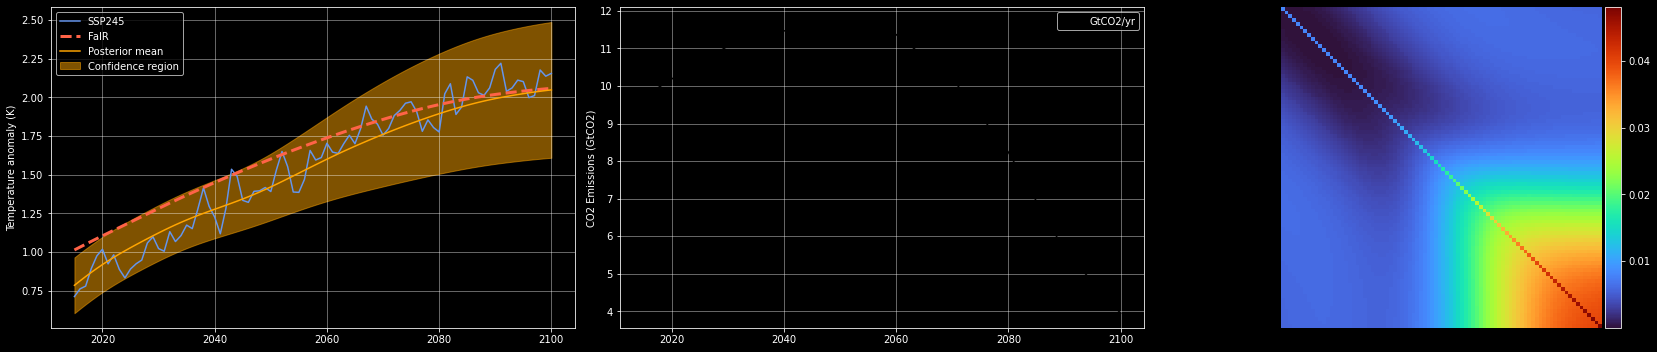

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))

ax[0].plot(test_times, test_tas, color='cornflowerblue', label='SSP245')
ax[0].set_ylabel('Temperature anomaly (K)')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=3, label='FaIR')
ax[0].plot(test_times, posterior_mean, color='orange', label='Posterior mean')
ax[0].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.5, color='orange', label='Confidence region')
ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].plot(test_times, test_scenarios.emissions[:, 0], label='GtCO2/yr', color='k')
ax[1].set_ylabel('CO2 Emissions (GtCO2)')
ax[1].grid(alpha=0.5)
ax[1].legend()


im = ax[2].imshow(noisy_pred.covariance_matrix, cmap='turbo')
colorbar(im)
ax[2].axis('off')

plt.tight_layout()
plt.show()

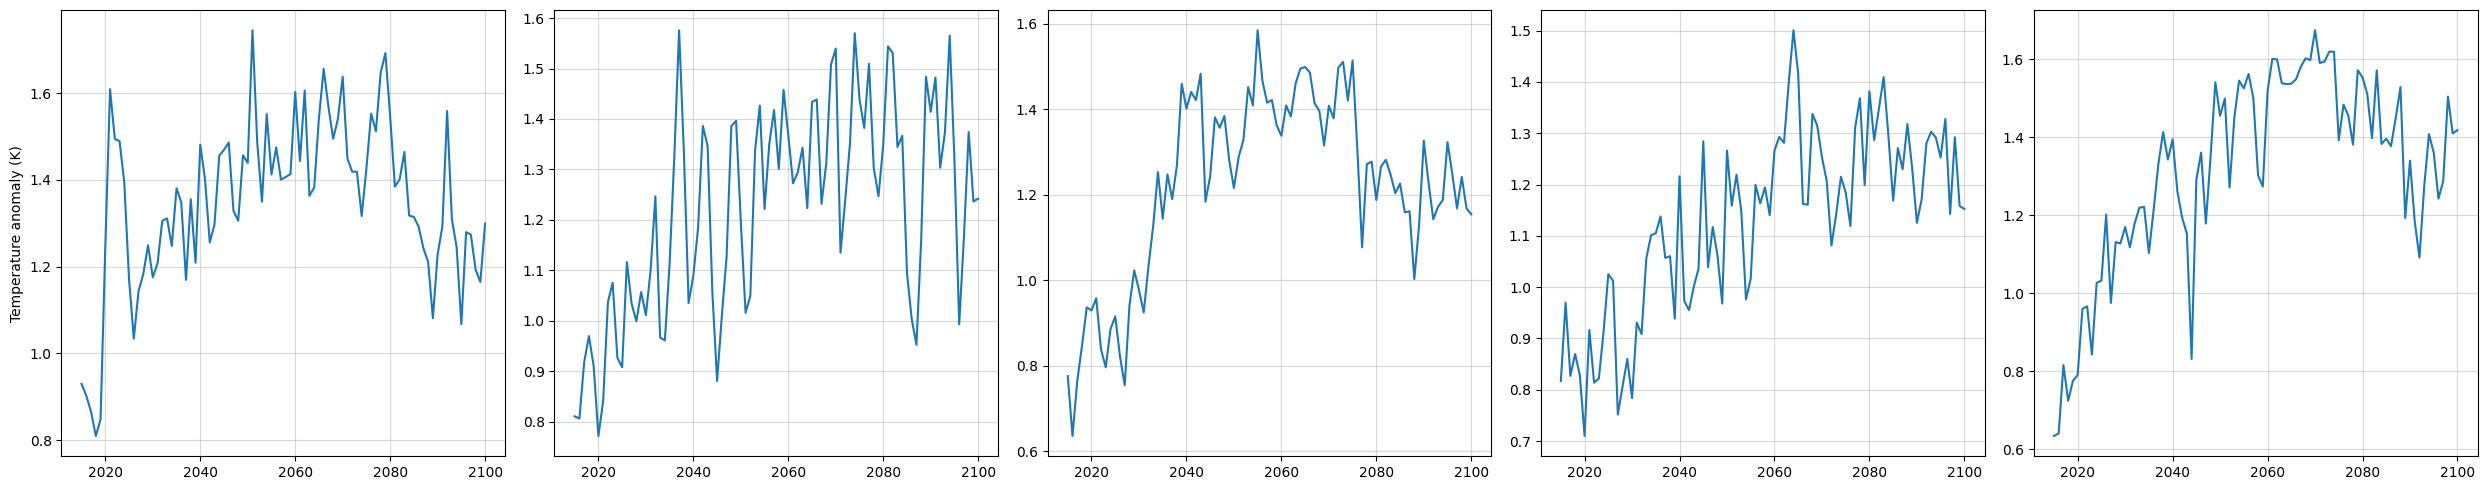

In [27]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
draws = noisy_pred.sample_n(5)
draws = draws + test_tas_fair
rdm_idx = torch.randperm(5)
for i in rdm_idx[:-1]:
    ax[i].plot(test_times, draws[i])
    ax[i].grid(alpha=0.5)
ax[rdm_idx[-1]].plot(test_times, test_tas)
ax[rdm_idx[-1]].grid(alpha=0.5)
ax[0].set_ylabel('Temperature anomaly (K)')
plt.tight_layout()
plt.show()

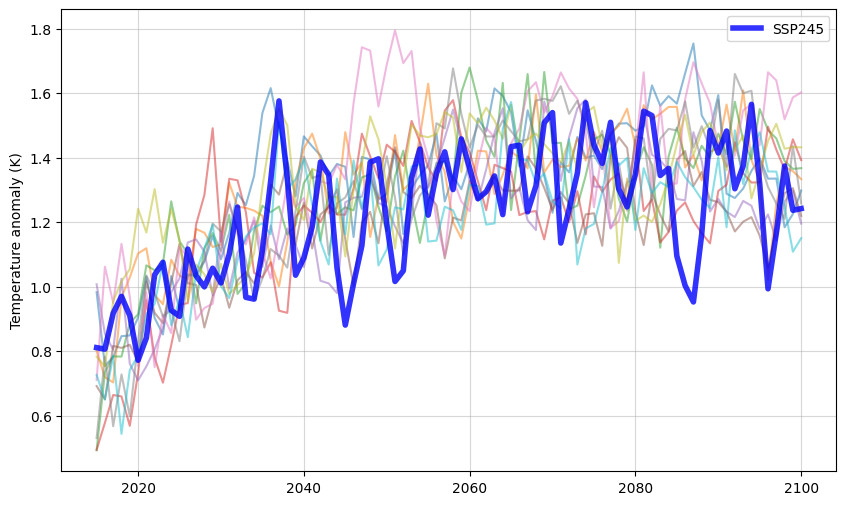

In [28]:
torch.random.manual_seed(5)
draws = noisy_pred.sample_n(10)
draws = draws + test_tas_fair

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.set_ylabel('Temperature anomaly (K)')
for draw in draws:
    ax.plot(test_times, draw, alpha=0.5)
ax.plot(test_times, test_tas, color='blue', label='SSP245', lw=4, alpha=0.8)
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [1]:
import pandas as pd

In [3]:
# emissions_only = pd.read_csv('../sandbox/output/dev/gfair-emissions-only/cv-scores.csv')
CO2_cumemission = pd.read_csv('../sandbox/output/dev/gfair-cumemissions-CO2/cv-scores.csv')
# CO2_CH4_cumemission = pd.read_csv('../sandbox/output/dev/gfair-cumemissions-CO2-CH4/cv-scores.csv')
# CO2_concentrations = pd.read_csv('../sandbox/output/dev/gfair-concentrations-CO2/cv-scores.csv')
# CO2_CH4_concentrations = pd.read_csv('../sandbox/output/dev/gfair-concentrations-CO2-CH4/cv-scores.csv')
# logsqrt_concentrations = pd.read_csv('../sandbox/output/dev/gfair-concentrations-log-sqrt/cv-scores.csv')

In [12]:
CO2_cumemission.iloc[[0, 3]].aggregate(['mean', 'std'])

,mb,rmse,mae,corr,ll,calib95,ICI
mean,-0.001399,0.183588,0.144502,0.843085,0.313856,0.930233,0.048531
std,0.088400,0.027064,0.026359,0.201219,0.123408,0.000000,0.037822


In [13]:
gp.iloc[[0, 3]].aggregate(['mean', 'std'])

,mb,rmse,mae,corr,ll,calib95,ICI
mean,-0.045989,0.288609,0.199993,0.825933,0.112088,0.970930,0.114443
std,0.188050,0.154728,0.087851,0.178897,0.109850,0.041111,0.062315


In [14]:
fair_df.iloc[[0, 3]].aggregate(['mean', 'std'])

,mb,rmse,mae,corr
mean,0.023874,0.226609,0.180612,0.829786
std,0.085449,0.066394,0.050583,0.221118


In [4]:
CO2_cumemission.aggregate(['mean', 'std'])

,mb,rmse,mae,corr,ll,calib95,ICI
mean,0.006434,0.162794,0.129697,0.910149,0.444186,0.953488,0.035526
std,0.061661,0.036952,0.028074,0.139625,0.202236,0.028482,0.026502


In [75]:
logsqrt_concentrations.aggregate(['mean', 'std'])

,mb,rmse,mae,corr,ll,calib95,ICI
mean,0.005393,0.167667,0.133323,0.910043,0.411791,0.930233,0.051377
std,0.071223,0.026420,0.019829,0.140600,0.184213,0.044531,0.037198


In [6]:
gp = pd.read_csv('../sandbox/output/dev/gp/cv-scores.csv')
gp.aggregate(['mean', 'std'])

,mb,rmse,mae,corr,ll,calib95,ICI
mean,-0.055256,0.221926,0.162083,0.903237,0.255444,0.985465,0.124449
std,0.132578,0.129448,0.078975,0.136514,0.283835,0.029070,0.064780


In [8]:
fair_df = pd.read_csv('../sandbox/output/dev/fair/cv-scores.csv')
fair_df.aggregate(['mean', 'std'])

,mb,rmse,mae,corr
mean,0.072403,0.215148,0.177461,0.903034
std,0.078960,0.054659,0.045760,0.153154
